# Multitaper coherence with gaps

The following textbook example was taken from Example 4.21 in the 4th edition of the Shumway & Stoffer time series text where the authors investigated the relationship between the Southern Oscillation Index and recruitment from fish populations. The data are plotted in Fig. 1.5 (p 5), and sampled monthly for a total of 453 samples. We have introduced a 49-sample gap in the data, where the gappy series is shown in black overlaid on the original series in blue.

In [1]:
using Statistics, FFTW, Arpack, LinearAlgebra, Distributions, Multitaper, DelimitedFiles, Plots
tog = true;
try 
    using RCall
catch
    tog = false;
    println("If you have RCall.jl and an R installation with the astsa package, you can run Shumway and Stoffer's original code. Continuing without it.")
end

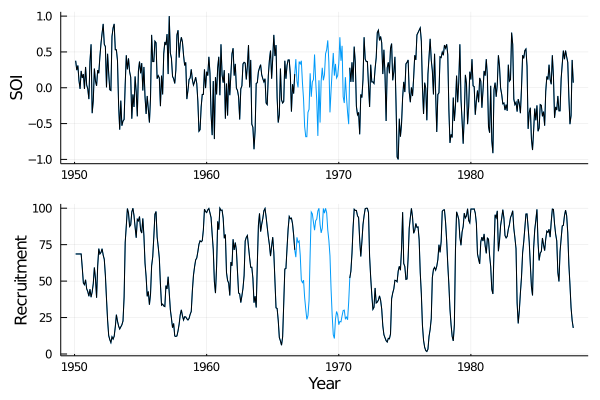

In [16]:
gaptimes = vcat(collect(1:200),collect(250:453))
MTdir = dirname(dirname(pathof(Multitaper)))

fn  = "/Examples/data/soirecruitment.dat"
dat = readdlm(MTdir*fn)
N1, p = size(dat)

# Variances of the two series
s1 = var(dat[:,3])
s2 = var(dat[:,4])

p = plot(dat[:,1] .+ dat[:,2]/12, dat[:,3:4], layout=(2,1), legend=false, 
    ylabel = ["SOI" "Recruitment"], xlabel = ["" "Year"])#,xlim=[1960,1965])
p = plot!(dat[collect(1:200),1].+dat[collect(1:200),2]/12, dat[collect(1:200),3:4], layout=(2,1), legend=false, 
    c = :black)
p = plot!(dat[collect(250:453),1].+dat[collect(250:453),2]/12, dat[collect(250:453),3:4], layout=(2,1), legend=false, 
    c = :black)

Fig. 4.15 (p 212) shows the estimate of the squared coherence computed using standard Daniell tapering and smoothing exactly as in the example from Shumway & Stoffer.

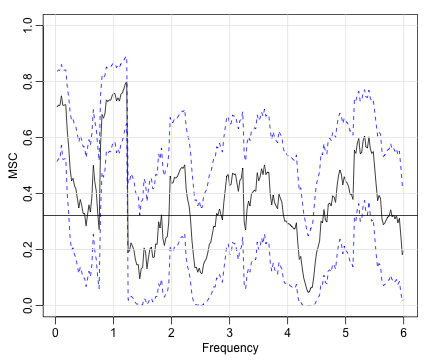

(OrderedCollections.OrderedDict{Symbol,Any}(:coef => [0.05263157894736842, 0.05263157894736842, 0.05263157894736842, 0.05263157894736842, 0.05263157894736842, 0.05263157894736842, 0.05263157894736842, 0.05263157894736842, 0.05263157894736842, 0.05263157894736842],:m => 9), 0.05263157894736842)

In [17]:
if tog 

R"""
library(astsa)
png("/users/charlottehaley/Documents/Repos/gaps/Doc/Figures/Rmsc_soirec.png")
dev.new(width=7, height=4) # default is 7 x 7 inches
par(mar=c(3,3,1,1), mgp=c(1.6,.6,0) )
ker = kernel("daniell",9)
sr = mvspec(cbind(soi,rec), kernel("daniell",9), plot=FALSE)
sr$df # df = 35.8625
f = qf(.999, 2, sr$df-2) # = 8.529792
C = f/(18+f) # = 0.321517
plot(sr, plot.type = "coh", ci.lty = 2, main="", xlab = "Frequency", ylab="MSC")
grid(lty=1, col=gray(.9))
abline(h = C)
dev.off()""";

@rget sr
@rget ker

plot(sr[:freq],Multitaper.unwrapphase(sr[:phase][:]*180/pi))

ker, 1/19

else
    println("This cell would have run the R code, if available.")
end

In the next figure, solid lines show the multitaper version of the spectrum, MSC estimate, and phase, where time-bandwidth product was set to 5 and 6 tapers were used. The gappy spectrum estimates, coherences, and phases, are shown with dotted lines. In comparison with the standard periodogram estimate, the multitaper requires much less smoothing to be consistent.

In [18]:
# Compute multitaper spectrum/coherences
NW = 5.0
K  = 6
dt = 1.0/12

multiv = multispec(dat[:,3:4], dt = dt, NW = NW, 
    K = K, jk = true, Ftest = true, guts = true, pad = 2.0)

N = length(gaptimes)
nz = 2*N1/N - 1
M = multiv[1][1].params.M

cross_pkg = mdmultispec(gaptimes, dat[gaptimes,3:4], nz=nz, dt=dt);

A plot of the spectra and coherences for the data without gaps (solid lines) and with gaps (dashed lines) shows good agreement. Note, the spectra show slightly larger values for the gappy series because there is a factor of 1/N in the normalizing constant, and N is smaller for the gappy series.

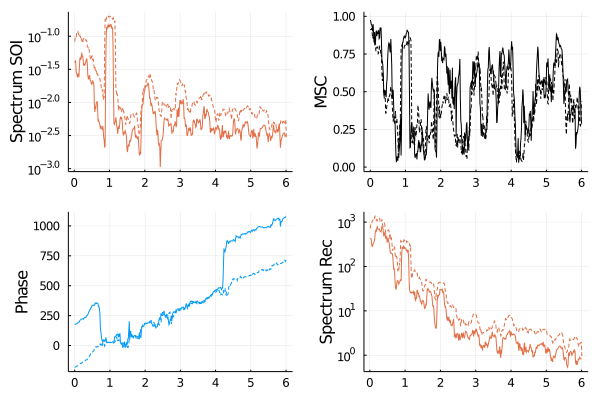

In [19]:
plot(multiv, ylabel=["Spectrum SOI" "MSC" "Phase" "Spectrum Rec"], legend=false)
plot!(cross_pkg, linestyle=:dash)

Putting it altogether, we can compare the estimates all in one 4-panel plot, omitting confidence intervals for now. We'll highlight the El Nino band with yellow.

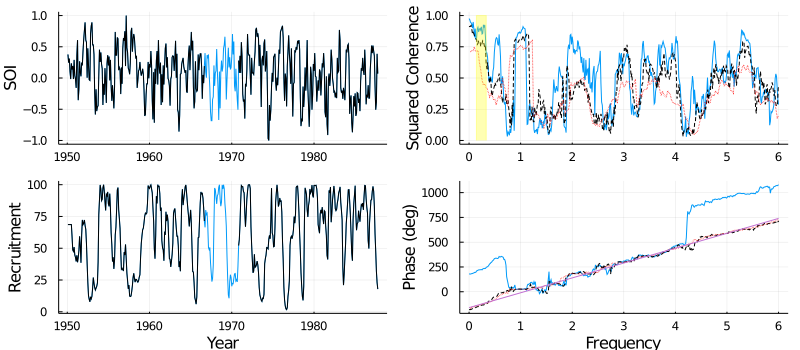

In [20]:
q = plot(multiv[2], phase = true, legend = false, 
    label = "Multitaper estimate")
q = plot!(cross_pkg[2][1,2].f, [Multitaper.tanhtrans.(cross_pkg[2][1,2].coh, 9) cross_pkg[2][1,2].phase],
    c = :black, layout = (2, 1), linestyle = :dash, 
    label = "MT with gaps")
if tog
q = plot!(sr[:freq], [sr[:coh] Multitaper.unwrapphase(sr[:phase][:]*180/pi,:deg)], layout = (2,1), 
    c = :red, linestyle=:dot, 
    label = "R coherence estimate")
end
plot!(q, vcat((1/7)*ones(2,1),(1/3)*ones(2,1)),[0,1,1,0],
    fill = (0,0.3,:yellow), line=(:yellow, 0.3), 
    label = "El Nino band")
plot!(q, [0, 6], [200, 1100] .- 360.0, subplot = 2, layout = (2, 1), 
    label = "Estimated linear phase")

plot(p, q, layout = (1, 2), size = (800, 350))

The slope of the phase is approximately 150 degrees per cycle per year, which amounts to a delay of recruitment with respect to SOI, in months, of:

In [21]:
(900/6)*(pi/180)*(12/(2*pi))

5.0

Alternatively, one can interpret this as a delay of SOI with respect to recruitment of 7 months. However, it is more likely that recruitment is dependent on SOI than the other way around. 

## An in-depth look at the MSC

Let's plot both of the multitaper coherence estimates together to see how they differ.

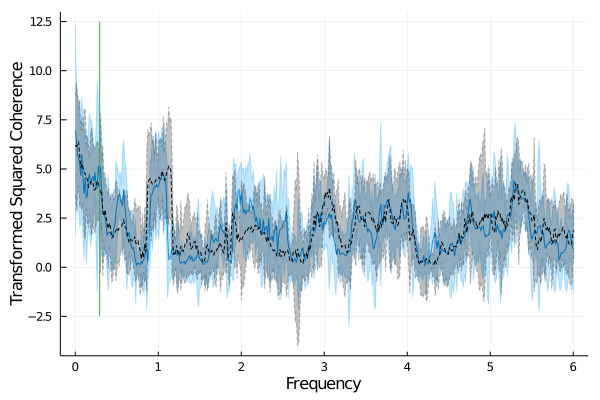

In [22]:
pp = plot(multiv[2][1, 2], legend = false, xlim = [0, 6],
    ylabel = "Transformed MSC", 
    label = "MT estimate")
plot!(pp, cross_pkg[2][1, 2], linestyle = :dash, c = :black,
    label = "MT with gaps")
plot!((1/3.4)*ones(2, 1), [-2.5, 12.5])

To see how similar the coherence estimates are to each other, one can compute confidence limits using leave-one-out jackknifing, described in Thomson and Chave (1991) for the estimates with and without the gaps. Note that the coherence here is shown on a transformed scale, described in the original paper. 

In [24]:
# This bonus plots recipe for coherences is not built in because of a feature of Plots.jl 
# that would require Plots.jl to become a dependency, so we load it in separately:
using RecipesBase
include(MTdir*"/src/PlotsRecipes/Coherence_plot.jl")

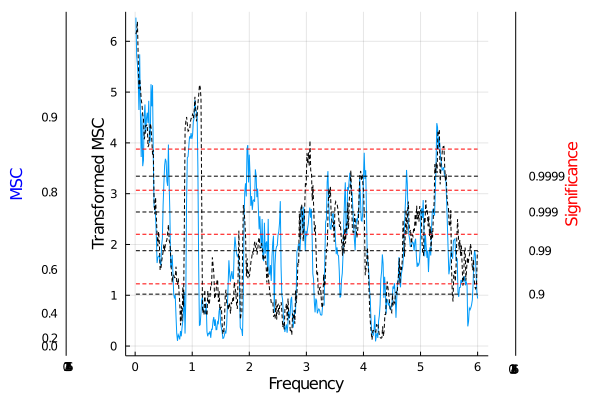

In [25]:
plot(multiv[2][1,2], siglines = true, msclines = false, sigMax = 4, legtext = false, 
       force_ylims = nothing, mscaxis = true, sigaxis = true, jk = false)
plot!(cross_pkg[2][1,2], c = :black, linestyle=:dash, msclines = false, jk = false)

## A closer look at the phase

Note that the phases in the bottom left of the 4-panel plot above resemble each other but are sometimes offset by 360 degrees. This would mean they are equivalent, but to compare these better, one can look at the angle of the phase factor, i.e. 

$$ \frac{e^{i\phi_1}}{e^{i\phi_2}}. $$

The angle of the phase factor is shown in the next figure.

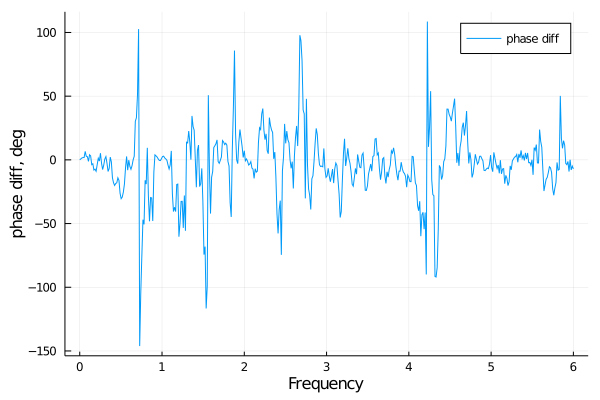

In [26]:
phase_factor = (180.0/pi)*angle.(exp.(1.0im*cross_pkg[2][1, 2].phase*(pi/180.0))./exp.(1.0im*multiv[2][1,2].phase*(pi/180.0)))

plot(multiv[2][1,2].f, phase_factor, label="phase diff",ylabel="phase diff, deg", xlabel="Frequency")

The result of the phase comparison is that there are some large-ish differences in numerous places, but this difference tends to center around 0.

The coherence difference is perhaps less meaningful because it is in transformed arctanh units. It is more helpful to look at the confidence intervals on the above plot and see where the gappy one exits the CI.

In search of a better phase comparison, we compute the phase factors for each of the estimates where the comparison is done against the estimated line of best fit (circular subtraction of the line y = 150x + 180).

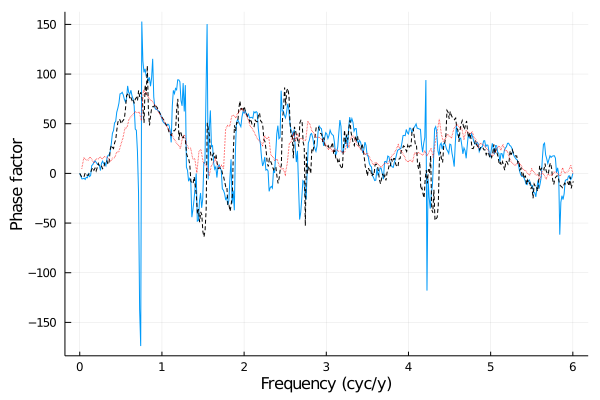

In [27]:
lobfun(f) = -180 .+ 150.0*f
phase_fact(f, p) = (180.0/pi)*angle.(exp.(1.0im*p*(pi/180.0))./exp.(1.0im*lobfun.(f)*(pi/180.0)))

r = plot(multiv[2][1,2].f, phase_fact(multiv[2][1,2].f, multiv[2][1,2].phase),
    label = "MT phase estimate", xlabel = "Frequency (cyc/y)", ylabel = "Phase factor",
    legend = false)
r = plot!(cross_pkg[2][1,2].f, phase_fact(cross_pkg[2][1,2].f, cross_pkg[2][1,2].phase),
    line = (:black, :dash),
    label = "MT phase w gaps")
if tog
r = plot!(sr[:freq], phase_fact(sr[:freq], Multitaper.unwrapphase(sr[:phase][:]*180/pi,:deg)),
    line = (:red, :dot),
    label = "SS phase")
end

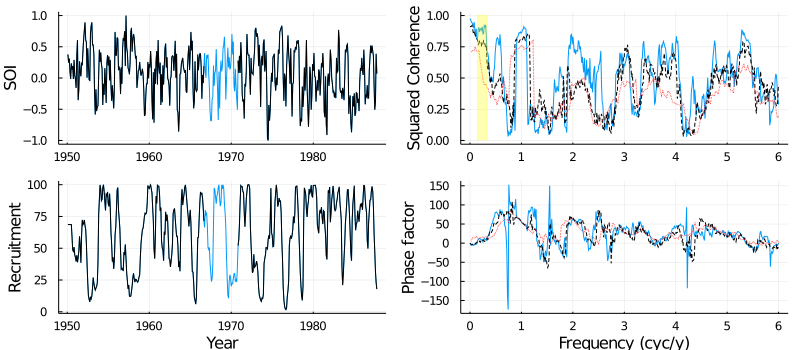

In [28]:
qr = plot(multiv[2], phase = false, legend = false, 
    label = "Multitaper estimate")

qr = plot!(cross_pkg[2][1,2].f, Multitaper.tanhtrans.(cross_pkg[2][1,2].coh, 9),
    c = :black, linestyle = :dash, 
    label = "MT with gaps")
if tog
qr = plot!(sr[:freq], sr[:coh],
    c = :red, linestyle=:dot, 
    label = "R coherence estimate")
end
plot!(qr, vcat((1/7)*ones(2,1),(1/3)*ones(2,1)),[0,1,1,0],
    fill = (0,0.3,:yellow), line=(:yellow, 0.3), 
    label = "El Nino band")

plot(p, plot(qr,r,layout=(2,1)), layout = (1, 2), size = (800, 350))

As we saw with the coherence estimate, the smoothing results in a periodogram-type estimate of the phase that is ultimately much smoother than that of the other two estimates. The multitaper estimator is allowed to vary more widely. 

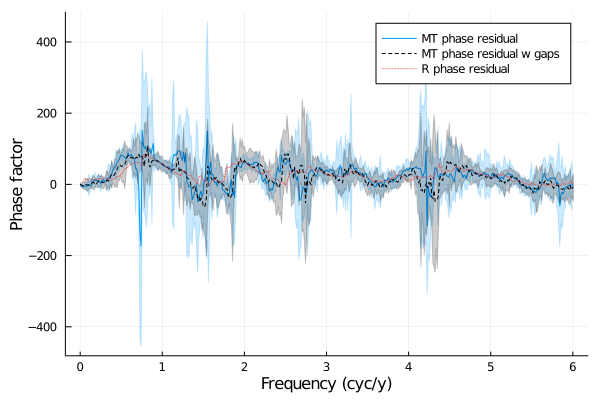

In [29]:
mtphasefact = phase_fact(multiv[2][1,2].f, multiv[2][1,2].phase)
mtgapphasefact = phase_fact(cross_pkg[2][1,2].f, cross_pkg[2][1,2].phase)

using StatsFuns
z = norminvcdf(0,1,0.975)

qq = plot(multiv[2][1,2].f, mtphasefact, c = 1,
    label = "MT phase residual", xlabel = "Frequency (cyc/y)", ylabel = "Phase factor")
plot!(qq, vcat(multiv[2][1,2].f, multiv[2][1,2].f[end:-1:1]), 
    vcat(mtphasefact,mtphasefact[end:-1:1]) .+ z*vcat((multiv[2][1,2].jkvar[2]), -(multiv[2][1,2].jkvar[2][end:-1:1]))
    , c = 1, fill = (0, 0.2), linealpha = 0.2, primary = false,
    label = "MT phase CI")
#=
#Cross shape
center = [0.5,400]
plot!(center[1] .+ (multiv[1][1].params.NW/multiv[1][1].params.N)*[-1.0, 1.0], center[2]*ones(2),c = 1,label="")
=#

plot!(qq, cross_pkg[2][1,2].f, mtgapphasefact,
    line = (:black, :dash),
    label = "MT phase residual w gaps")

plot!(qq, vcat(cross_pkg[2][1,2].f, cross_pkg[2][1,2].f[end:-1:1]), 
    vcat(mtgapphasefact,mtgapphasefact[end:-1:1]) .+ z*vcat((cross_pkg[2][1,2].jkvar[2]), -(cross_pkg[2][1,2].jkvar[2][end:-1:1]))
    , c = :black, fill = (0, 0.2), linealpha = 0.2, primary = false,
    label = "MT gaps phase CI")

if tog
plot!(qq, sr[:freq], phase_fact(sr[:freq], Multitaper.unwrapphase(sr[:phase][:]*180/pi,:deg)),
    line = (:red, :dot),
    label = "R phase residual")
end